---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-data-analysis/resources/0dhYG) course resource._

---

In [31]:
import pandas as pd
import numpy as np
import re
from scipy.stats import ttest_ind

# Assignment 4 - Hypothesis Testing
This assignment requires more individual learning than previous assignments - you are encouraged to check out the [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/) to find functions or methods you might not have used yet, or ask questions on [Stack Overflow](http://stackoverflow.com/) and tag them as pandas and python related. And of course, the discussion forums are open for interaction with your peers and the course staff.

Definitions:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.

**Hypothesis**: University towns have their mean housing prices less effected by recessions. Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

The following data files are available for this assignment:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. For this assignment, only look at GDP data from the first quarter of 2000 onward.

Each function in this assignment below is worth 10%, with the exception of ```run_ttest()```, which is worth 50%.

In [45]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [106]:
def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. The format of the DataFrame should be:
    DataFrame( [ ["Michigan", "Ann Arbor"], ["Michigan", "Yipsilanti"] ], 
    columns=["State", "RegionName"]  )
    
    The following cleaning needs to be done:

    1. For "State", removing characters from "[" to the end.
    2. For "RegionName", when applicable, removing every character from " (" to the end.
    3. Depending on how you read the data, you may need to remove newline character '\n'. '''
    
    df = pd.DataFrame(columns=["State", "RegionName"])
    
    # University_towns.txt contains state name in a line with "[" followed by several towns in that state
    with open('university_towns.txt') as fp:
        for line in fp:
            # Statename is identified by the lines containing "edit" in the name
            if 'edit' in line:
                current_state = line.split("[")[0]
            else:
                current_town = line.split("(")[0].rstrip()
                df = df.append(pd.DataFrame([[current_state, current_town]], columns=["State", "RegionName"]),
                               ignore_index = True)

    return df
get_list_of_university_towns().head(10)


,State,RegionName
0,Alabama,Auburn
1,Alabama,Florence
2,Alabama,Jacksonville
3,Alabama,Livingston
4,Alabama,Montevallo
5,Alabama,Troy
6,Alabama,Tuscaloosa
7,Alabama,Tuskegee
8,Alaska,Fairbanks
9,Arizona,Flagstaff


In [33]:
def get_recession_start():
    '''Returns the year and quarter of the recession start time as a 
    string value in a format such as 2005q3'''
    
    xl = pd.ExcelFile("gdplev.xls")
    
    # Only include rows that contain the data from year 2000 onwards
    gdp = (pd.read_excel(xl,skiprows=8+4*53,header=None)
      .iloc[:,4:7])
    gdp.columns = ['Quarter', 'GDP in billions of current dollars', 'GDP in billions of chained 2009 dollars']

    two_quarters_ago = gdp.iloc[0,2]
    last_quarter = gdp.iloc[1,2]
    recession_start_index = 0
    in_recession = False
    for i in range(2,len(gdp)):
        if (gdp.iloc[i,2] < last_quarter) & (last_quarter < two_quarters_ago):
            if not in_recession:
                recession_start_index = i-1
                in_recession = True
                break
        two_quarters_ago = last_quarter
        last_quarter = gdp.iloc[i,2]
    
    return gdp.iloc[recession_start_index,0]

get_recession_start()

'2008q3'

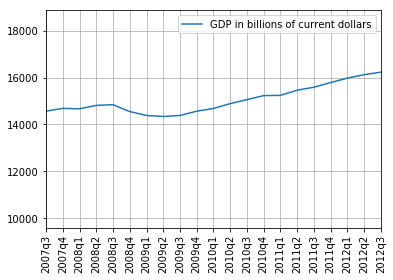

In [107]:
#Plot to show the GDP for the quarters around recession time
def plot2():
    import matplotlib as plt
    %matplotlib inline
    xl = pd.ExcelFile("gdplev.xls")
    gdp = (pd.read_excel(xl,skiprows=8+4*53,header=None)
      .iloc[:,4:7])
    gdp.columns = ['Quarter', 'GDP in billions of current dollars', 'GDP in billions of chained 2009 dollars']
    ax = gdp.plot(y='GDP in billions of current dollars', xticks=gdp.index, rot=90)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 1))
    ax.set_xticklabels(gdp.Quarter[np.arange(start, end, 1)])
    ax.set_xlim([30,50])
    ax.grid()
plot2()

In [34]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time as a 
    string value in a format such as 2005q3'''
    xl = pd.ExcelFile("gdplev.xls")
    gdp = (pd.read_excel(xl,skiprows=8+4*53,header=None)
      .iloc[:,4:7])
    gdp.columns = ['Quarter', 'GDP in billions of current dollars', 'GDP in billions of chained 2009 dollars']

    two_quarters_ago = gdp.iloc[0,2]
    last_quarter = gdp.iloc[1,2]
    recession_start_index = 0
    in_recession = False
    for i in range(2,len(gdp)):
        if (gdp.iloc[i,2] < last_quarter) & (last_quarter < two_quarters_ago):
            if not in_recession:
                recession_start_index = i-1
                in_recession = True
        if (gdp.iloc[i,2] > last_quarter) & (last_quarter > two_quarters_ago) & in_recession:
                recession_end_index = i
                in_recession = False
        two_quarters_ago = last_quarter
        last_quarter = gdp.iloc[i,2]
    
    return gdp.iloc[recession_end_index,0]

get_recession_end()


'2009q4'

In [35]:
def get_recession_bottom():
    '''Returns the year and quarter of the recession bottom time as a 
    string value in a format such as 2005q3'''
    
    xl = pd.ExcelFile("gdplev.xls")
    gdp = (pd.read_excel(xl,skiprows=8+4*53,header=None)
      .iloc[:,4:7])
    gdp.columns = ['Quarter', 'GDP in billions of current dollars', 'GDP in billions of chained 2009 dollars']

    two_quarters_ago = gdp.iloc[0,2]
    last_quarter = gdp.iloc[1,2]
    recession_start_index = 0
    recession_bottom_index = 0
    in_recession = False
    for i in range(2,len(gdp)):
        if (gdp.iloc[i,2] < last_quarter) & (last_quarter < two_quarters_ago):
            if not in_recession:
                recession_start_index = i-1
                recession_bottom_index = i
                in_recession = True
                
        if (gdp.iloc[i,2] > last_quarter) & (last_quarter > two_quarters_ago) & in_recession:
                recession_end_index = i
                in_recession = False
                
        if (gdp.iloc[i,2] < gdp.iloc[recession_bottom_index,2]) & in_recession:
                recession_bottom_index = i
                
        two_quarters_ago = last_quarter
        last_quarter = gdp.iloc[i,2]
        
    return gdp.iloc[recession_bottom_index,0]
get_recession_bottom()

'2009q2'

In [53]:
def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe. This dataframe should be a dataframe with
    columns for 2000q1 through 2016q3, and should have a multi-index
    in the shape of ["State","RegionName"].
    
    Note: Quarters are defined in the assignment description, they are
    not arbitrary three month periods.
    
    The resulting dataframe should have 67 columns, and 10,730 rows.
    '''
    housingdata = (pd.read_csv("City_Zhvi_AllHomes.csv")
                    .select(lambda x: not re.search('199', x), axis=1)
                   .drop(['RegionID','Metro','CountyName','SizeRank'],axis=1)
                  )
    housingdata.State = [states[x] for x in housingdata.State]
    housingdata = housingdata.set_index(['State', 'RegionName'])
    housingdata = housingdata.groupby(np.arange(len(housingdata.columns))//3, axis=1).mean()
    housingdata.columns = [str((2000 + x//4))+'q'+str(x%4+1) for x in range(67) ]
    return housingdata

convert_housing_data_to_quarters().head()

,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,...,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
State,RegionName,,,,,,,,,,,,,,,,,,,,,
New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.0
California,Los Angeles,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,...,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,584050.0
Illinois,Chicago,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,...,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,212000.0
Pennsylvania,Philadelphia,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,...,113733.333333,115300.000000,115666.666667,116200.000000,117966.666667,121233.333333,122200.000000,123433.333333,126933.333333,128700.0
Arizona,Phoenix,111833.333333,114366.666667,116000.000000,117400.000000,119600.000000,121566.666667,122700.000000,124300.000000,126533.333333,128366.666667,...,164266.666667,165366.666667,168500.000000,171533.333333,174166.666667,179066.666667,183833.333333,187900.000000,191433.333333,195200.0


In [105]:
def run_ttest():
    '''First creates new data showing the decline or growth of housing prices
    between the recession start and the recession bottom. Then runs a ttest
    comparing the university town values to the non-university towns values, 
    return whether the alternative hypothesis (that the two groups are the same)
    is true or not as well as the p-value of the confidence. 
    
    Return the tuple (different, p, better) where different=True if the t-test is
    True at a p<0.01 (we reject the null hypothesis), or different=False if 
    otherwise (we cannot reject the null hypothesis). The variable p should
    be equal to the exact p value returned from scipy.stats.ttest_ind(). The
    value for better should be either "university town" or "non-university town"
    depending on which has a lower mean price ratio (which is equivilent to a
    reduced market loss).'''
    recession_start = get_recession_start()
    recession_bottom = get_recession_bottom()
    housing_data = convert_housing_data_to_quarters()
    #Calculate the ration of mean housing price before recession to after recession
    housing_data['price_ratio'] = housing_data.iloc[:,housing_data.columns.get_loc(recession_start)-1]/housing_data.loc[:,recession_bottom]
    
    #Add a column saying whether a town is university town or not, to housingdata data frame
    univ_town_list = [tuple(x) for x in get_list_of_university_towns().values]
    housing_data['UniversityTown'] = list(map( lambda x: x in univ_town_list,housing_data.index))
    
    # t-test
    # We will be doing a two sample independent t-test. First identify the two samples:
    # one with the price ratio for the college towns, and one with the price ratio for the non-college towns
    price_ratio_college_towns = housing_data.where(housing_data.UniversityTown== True).dropna()['price_ratio']
    price_ratio_non_college_towns = housing_data.where(housing_data.UniversityTown== False).dropna()['price_ratio']

    # Obtain the p-value from the t-test.
    # The two samples are considered different if p-value is < 0.001
    # p-value represents that likelihood of observing the two distributions (with means at least that different)
    # if the null hypothesis (that their means are equal) is true. 
    
    pvalue = ttest_ind(price_ratio_college_towns,price_ratio_non_college_towns)[1]
    if price_ratio_college_towns.mean() <  price_ratio_non_college_towns.mean():
        better = "university town" 
    else:
        better = "non-university town"
    return (pvalue < 0.01, pvalue, better)

run_ttest()

(True, 0.0051648663279195324, 'university town')

## Conclusion: It was observed that university towns have their mean housing prices less effected by recessions